In [41]:
# Imports
import face_recognition
import matplotlib.pyplot as plt 
import cv2
import pandas as pd 
import numpy as np 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import squeezenet1_0
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
index_to_emotion=('Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

In [44]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers=nn.Sequential(
            nn.Linear(10368, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 7),
            nn.Softmax(),
        )
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.size(0), -1)
        out = self.linear_layers(out)
        return out
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
model = ConvNet()
model.to(device)
model.apply(init_weights)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10368, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=7, bias=True)
    (7): Softmax(dim=None)
  )
)

In [45]:
# Loading weights of model
model.load_state_dict(torch.load('emotion_detection.pth'))
model.eval()

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10368, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=7, bias=True)
    (7): Softmax(dim=None)
  )
)

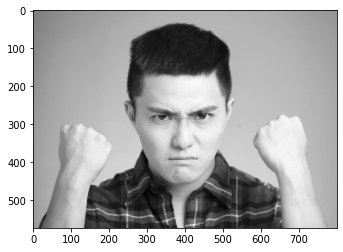

In [55]:
# Loading a sample image and testing the model
image = face_recognition.load_image_file("angry_face.jpg",mode='L')
face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=2 )
## Displaying image
plt.imshow(image,cmap='gray');

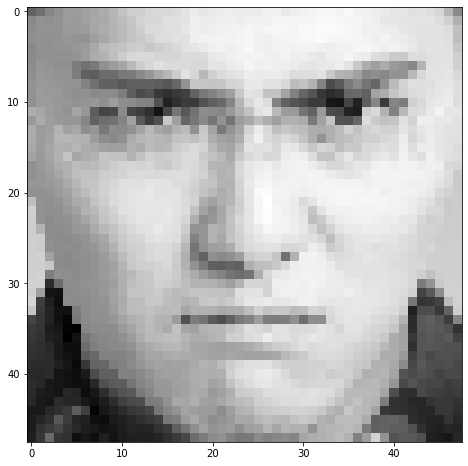

In [57]:
## Cropping all the image and displaying them
fig=plt.figure(figsize=(8, 8))
columns = 1
faces=[]
rows = rows=(len(face_locations))
for i,face in enumerate(face_locations,1):
    fig.add_subplot(rows, columns, i)
    face_in_image=image[face[0]:face[2],face[3]:face[1]]
    faces.append(cv2.resize(face_in_image,(48,48)))
    plt.imshow(cv2.resize(face_in_image,(48,48)),cmap='gray') ## We are training data on 48*48 images
plt.show()

In [48]:
faces = np.array(faces)
faces = faces.astype(np.uint8)
faces.shape

(1, 48, 48)

In [49]:
transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
def as_input_for_model(batch):
    batch = transform(batch)
    print(type(batch))
    batch.unsqueeze_(0)
    return batch

In [50]:
result = model.forward(as_input_for_model(faces[0]))
result.shape,result

<class 'torch.Tensor'>


(torch.Size([1, 7]),
 tensor([[7.6851e-01, 7.7765e-13, 1.2366e-07, 1.9429e-11, 2.3149e-01, 4.0776e-23,
          1.7489e-13]], grad_fn=<SoftmaxBackward>))

In [51]:
index_to_emotion[torch.max(result,1)[1].item()]

'Angry'

In [52]:
torch.max(result,1)[1].item()

0

In [53]:
import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("Emotion detection")

img_counter = 0

while True:
    ret, frame = cam.read()
    #print(frame.shape)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    try:
        face_locations = face_recognition.face_locations(gray, number_of_times_to_upsample=2 )
        for x in face_locations:
            start_point = (x[3], x[0]) 
            end_point = (x[1], x[2]) 
            color = (255, 0, 0) 
            thickness = 2
            frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
            face = cv2.resize(gray[x[0]:x[2],x[3]:x[1]],(48,48))
            face = transform(face).unsqueeze_(0)
            result=index_to_emotion[torch.max(model.forward(face),1)[1].item()]
            cv2.putText(frame, result, (x[3], x[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    except:
        print("Error Occured")    
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("Emotion detection", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break

cam.release()

cv2.destroyAllWindows()

Escape hit, closing...


In [54]:
gray.shape

(480, 640)